# Rabi Cycle

- Quantum Algorithm for Time-Dependent Hamiltonian Simulation by Permutation Expansion ([here](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.030342))
- Rabi Cycle Document ([here](https://drive.google.com/file/d/1Zt7ElAQkwPb9YGTptcb9iPo2liSLBOC7/view?usp=sharing))

In [1]:
import qiskit as q
import numpy as np
import matplotlib as mpl
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library.standard_gates.z import ZGate

### Assigning Qubit numbers 

In [2]:
i1 = 14
i2 = 13
i3 = 12
i4 = 11
k1 = [10, 9]
k2 = [8, 7]
k3 = [6, 5]
k4 = [4, 3]
x = 2
z = 1
ancilla = 0

### Initializing the quantum registers

In [3]:
q_i = q.QuantumRegister(4, 'i_reg')
q_k = q.QuantumRegister(8, 'k_reg')
q_x = q.QuantumRegister(1, 'x')
q_z = q.QuantumRegister(1, 'z')
q_ancilla = q.QuantumRegister(1, 'ancilla')
c_z = q.ClassicalRegister(1, 'measure_z')

### Calculating $s_q$ values

$s_q = \frac{(ln 2)^q}{q!}$

In [4]:
ln2 = np.log(2)
s = [(ln2 ** q)/np.math.factorial(q) for q in range(0, 5)]

### Calculating $\theta$ values

$\theta_i = 2\tan^{-1}{\sqrt{\frac{\sum_{q=i}^{4} s_q}{s_{i-1}}}}$

In [5]:
theta = [2*np.arctan(np.sqrt(np.sum(s[i:5])/s[i - 1])) for i in range(1, 5)]
theta = [0] + theta

## 1. State Preparation

$ |\psi_0 \rangle = \frac{1}{\sqrt{s}} \sum_{q = 0}^{4} \sum_{\textbf{i}_q} \sum_{\textbf{k}_q} \sum_{x = 0, 1} \sqrt{\frac{(\ln{2})^q}{2q!}} | \textbf{i}_q \rangle | \textbf{k}_q \rangle |x \rangle$

In [6]:
def state_prep():
    qc = q.QuantumCircuit(15, name='state prep')
    qc.h(x)
    qc.u(theta[1], 0, 0, i1)
    qc.cu(theta[2], 0, 0, 0, i1, i2)
    qc.cu(theta[3], 0, 0, 0, i1, i3)
    qc.cu(theta[4], 0, 0, 0, i1, i4)
    qc.barrier()
    qc.cx(i1, k1[1])
    qc.cx(i2, k2[1])
    qc.cx(i3, k3[1])
    qc.cx(i4, k4[1])
    qc.barrier()
    qc.ch(i1, k1[0])
    qc.ccx(i1, k1[0], k1[1])
    qc.ch(i2, k2[0])
    qc.ccx(i2, k2[0], k2[1])
    qc.ch(i3, k3[0])
    qc.ccx(i3, k3[0], k3[1])
    qc.ch(i4, k4[0])
    qc.ccx(i4, k4[0], k4[1])
    return qc

#### Testing state preparation

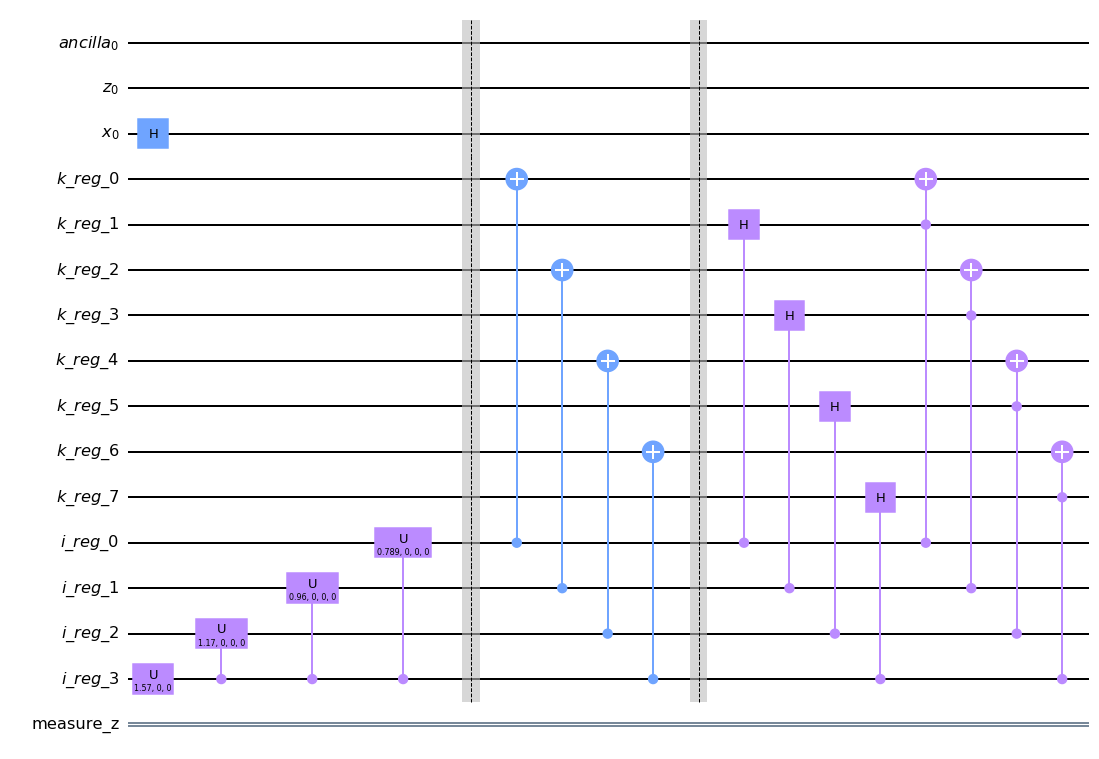

In [28]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(state_prep(), range(0, 15))
qc.decompose().draw(output='mpl')

## 2. Controlled Unitaries

#### $V_{c P} | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle | z \rangle = | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle P_{\textbf{i}_q} |z \rangle$

In [8]:
def V_cP():
    qc = q.QuantumCircuit(15, name='V_cP')
    qc.cx(i1, z)
    qc.cx(i2, z)
    qc.cx(i3, z)
    qc.cx(i4, z)
    return qc

#### Testing $V_{cP}$

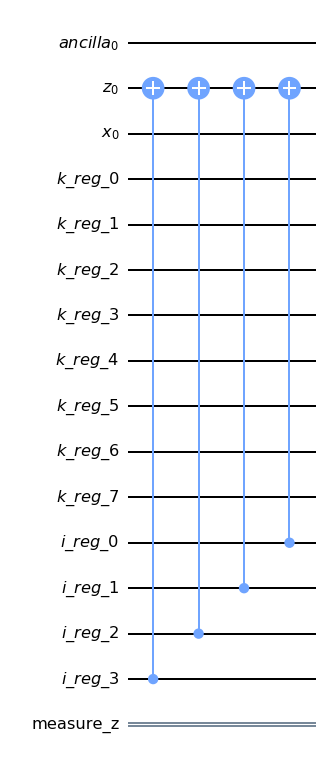

In [9]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(V_cP(), range(0, 15))
qc.decompose().draw(output='mpl')

#### $V_{c i} | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle | z \rangle = | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle (-1)^q |z \rangle$

In [10]:
def V_ci():
    qc = q.QuantumCircuit(15,name='V_ci')
    qc.s(i1).inverse()
    qc.s(i2).inverse()
    qc.s(i3).inverse()
    qc.s(i4).inverse()
    return qc

#### Testing $V_{ci}$

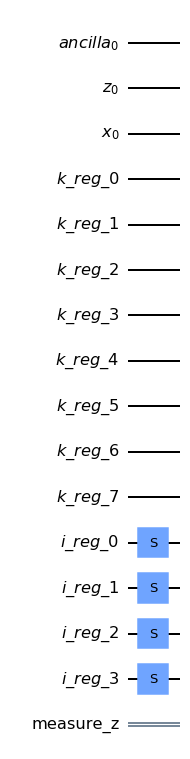

In [11]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(V_ci(), range(0, 15))
qc.decompose().draw(output='mpl')

### Lookup table $\alpha_{(q, x, z)}$
$\alpha_{(q, x, z)} \equiv \theta_{{\textbf{i}_q}, z}^{({\textbf{k}_q})} + (-1)^x \phi_{{\textbf{i}_q}, z}^{({\textbf{k}_q})}$

In [12]:
lookup = {
    "100": 5.98807,
    "101": 1.09118,
    "110": 5.19201,
    "111": 0.29512,
    "200": 0.78343,
    "201": 6.14915,
    "210": 0.13403,
    "211": 5.49975,
    "300": 5.89860,
    "301": 1.00171,
    "310": 5.28148,
    "311": 0.38459,
    "400": 0.82954,
    "401": 6.00575,
    "410": 0.27744,
    "411": 5.45365,
}

$U_{\Phi}(q, x, z) = \begin{pmatrix}
       1 & 0 \\
       0 & e^{i \alpha_{(q, x, z)}}
    \end{pmatrix}$

In [13]:
def U_qxz(q_val, x_val, z_val):
    key = str(q_val) + str(x_val) + str(z_val)
    qc = q.QuantumCircuit(1)
    qc.p(lookup[key], 0)
    return qc

#### $V_{c \phi} | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle | z \rangle = | \textbf{i}_q \rangle | \textbf{k}_q \rangle | x \rangle \Phi_{{\textbf{i}_q}, x}^{({\textbf{k}_q}, w)} |z \rangle$

In [14]:
def V_cphi():
    qc = q.QuantumCircuit(15, name='V_cphi')
    qc.x(ancilla)
    for key in lookup.keys():
        q_val, x_val, z_val = key
        ctrl_state = z_val + x_val + "0"*(4 - int(q_val)) + "1"*int(q_val)
        gate = U_qxz(q_val, x_val, z_val).to_gate(label='U_phi({},{},{})'.format(q_val, x_val, z_val)).control(6, ctrl_state=ctrl_state)
        qc.append(gate, [i1, i2, i3, i4, x, z,ancilla])
    qc.x(ancilla)    
    return qc

#### Testing $V_{c \phi}$

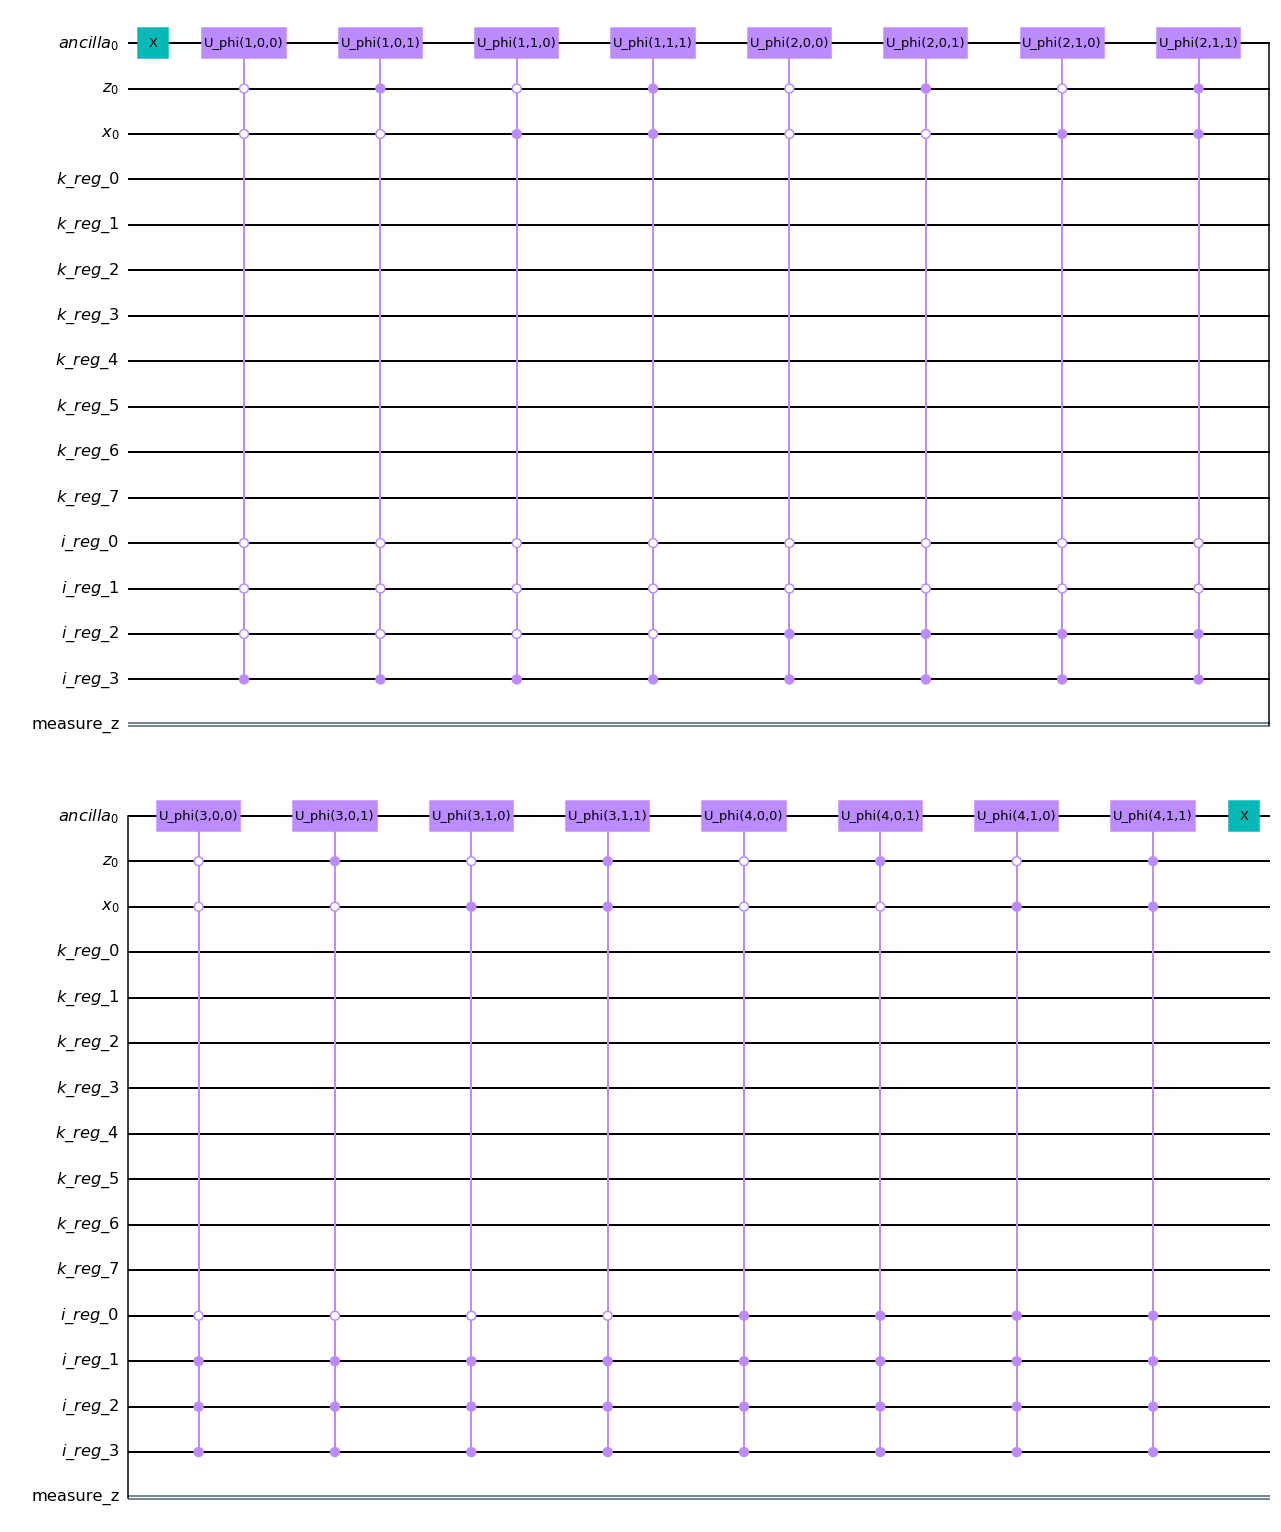

In [15]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(V_cphi(), range(0, 15))
qc.decompose().draw(output='mpl')

## 3. Combining state preparation and controlled unitaries

#### $W = ( B ^{\dagger} \otimes \mathbb{1}) V_{c i} V_{c P} V_{c \phi} ( B \otimes \mathbb{1})$
where $B$ is the state preparation unitary $B |0 \rangle = | \psi_0 \rangle$

In [16]:
def W(global_phase = 0):
    qc = q.QuantumCircuit(15, name='W', global_phase = global_phase)
    qc.append(state_prep(), range(0, 15))
    qc.barrier()
    qc.append(V_cphi(), range(0, 15))
    qc.barrier()
    qc.append(V_cP(), range(0, 15))
    qc.barrier()
    qc.append(V_ci(), range(0, 15))
    qc.barrier()
    qc.append(state_prep().inverse(), range(0, 15))
    qc.barrier()
    return qc

#### Testing $W$

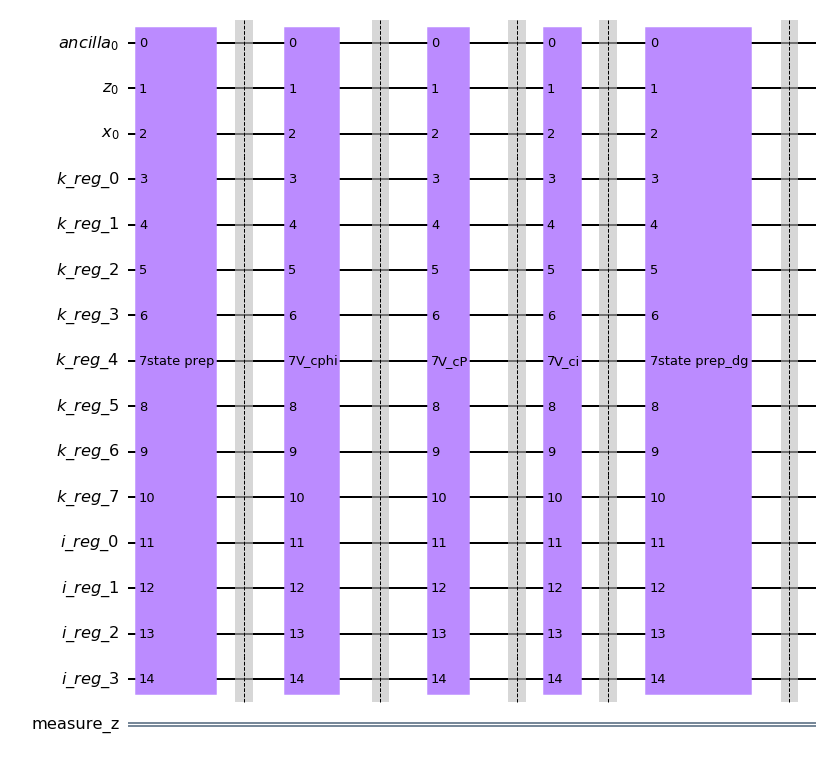

In [17]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(W(), range(0, 15))
qc.decompose().draw(output='mpl')

#### $R = \mathbb{1} - 2( | 0 \rangle \langle 0 | \otimes \mathbb{1})$

In [18]:
def R():
    qc = q.QuantumCircuit(13, name='R')
    qc.x(range(0, 13))
    zgate = ZGate().control(12, ctrl_state='111111111111')
    qc.append(zgate, range(12, -1, -1))
    qc.x(range(0, 13))
    return qc

#### Testing $R$

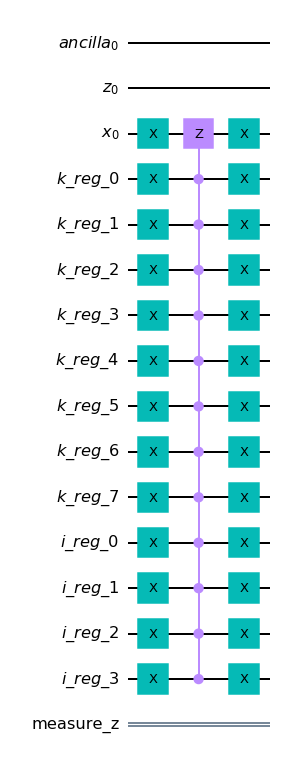

In [19]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(R(), range(2, 15))
qc.decompose().draw(output='mpl')

#### $A = - WRW^{\dagger} RW$

In [20]:
def A():
    qc = q.QuantumCircuit(15, name='A')
    qc.append(W(), range(0, 15))
    qc.append(R(), range(2, 15))
    qc.append(W().inverse(), range(0, 15))
    qc.append(R(), range(2, 15))
    qc.append(W(global_phase=np.pi), range(0, 15))
    return qc

#### Testing $A$

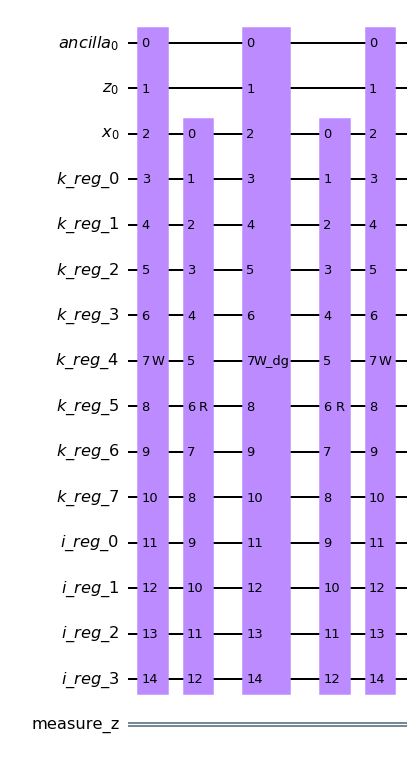

In [21]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(A(), range(0, 15))
qc.decompose().draw(output='mpl')

## 4. Principal diagonal matrix $H_0$

$ H_0 = Z $

$ e^{-i \Delta t H_0} = e^{-i \ln 2 Z} = \begin{pmatrix}
       e^{-i \ln 2} & 0 \\
       0 & e^{i \ln 2}
    \end{pmatrix}$

In [22]:
def principal_diag():
    qc = q.QuantumCircuit(1, name="p_diag")
    qc.rz(2*ln2, 0)
    return qc

#### Testing $e^{-i \Delta t H_0}$

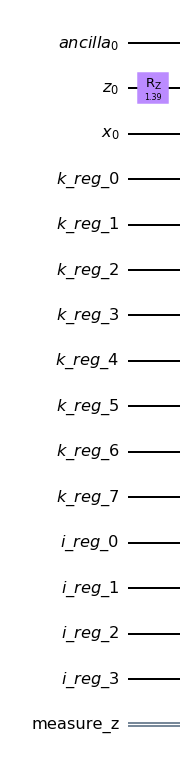

In [23]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)
qc.append(principal_diag(), [1])
qc.decompose().draw(output='mpl')

## 5. Final Quantum Circuit

### Initializing the quantum circuit

In [24]:
qc = q.QuantumCircuit(q_ancilla, q_z, q_x, q_k, q_i, c_z)

### Setting the running time

The running time is set in multiples of $\ln{2}$ because $\Delta t = \ln{2}$

In [25]:
running_time = ln2 * 5

for i in range(int(running_time / ln2)):
    qc.append(principal_diag(), [z])
    qc.append(A(), range(0, 15))

qc.measure(q_z, c_z)

### Drawing the quantum circuit (high level overview)

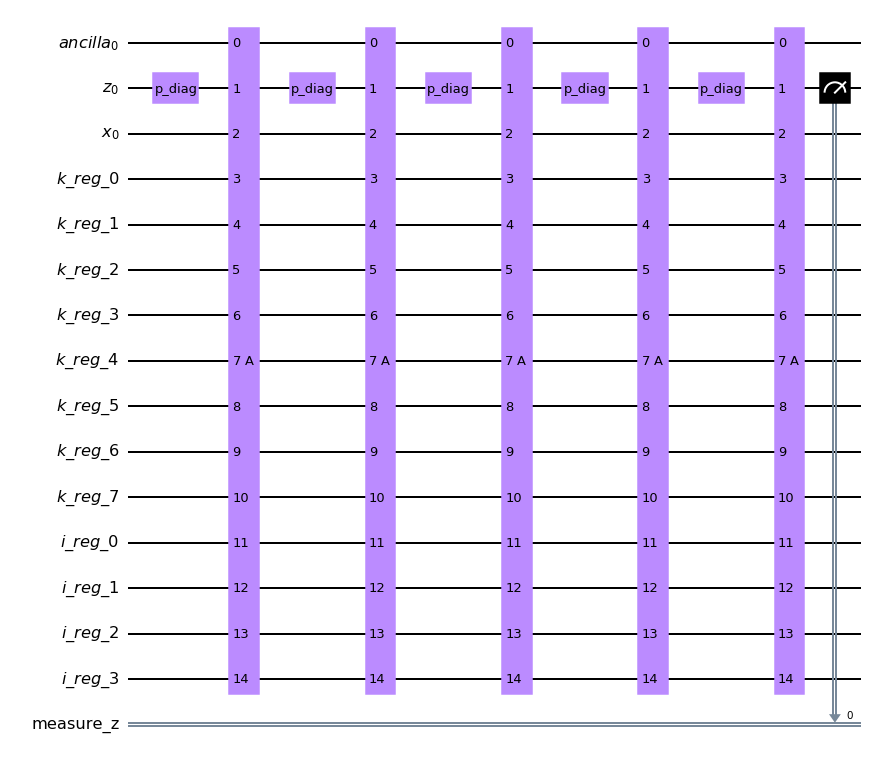

In [26]:
qc.draw(output='mpl')

### Running the quantum circuit on a simulator and printing results

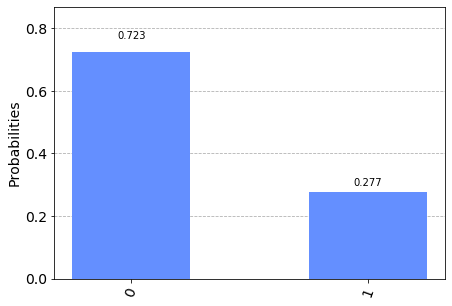

In [27]:
backend = q.Aer.get_backend('qasm_simulator')
job = q.execute(qc, backend, shots=1000)
result = job.result()
counts = result.get_counts(qc)
graph = q.visualization.plot_histogram(counts)
display(graph)